In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import keras# .preprocessing.sequence import TimeseriesGenerator
from google.colab import drive
drive.mount('/content/gdrive')
import matplotlib.pyplot as plt

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
file_path = './gdrive/My Drive/sp500.csv'
validation_percent = 10
test_percent = 10
test_length=None
validation_length=None
batch_size = 32
stride=1
sampling_rate = 1
length=60

In [0]:
class SP500Dataset:

    def __init__(self, train=None, valid=None, test=None):
        """
        S&P500 data split into train, validation and test datasets loaded using load_data method        
        """
        assert train is not None, 'CSV file not loaded, use load_data method first'
        
        self.train = train
        self.valid = valid
        self.test = test
        self.scalers = {}
        self.scaler_feature_range = (10**-7, 1)
        self.generator = {}
        self.stock_merged_start_index = {}
    def get_generator(self, dataset_type='train', stocks=None, merged=False, batch_size = 32, stride = 1, sampling_rate = 1, seq_length = 60):
        """
        This function creates generators to be used with the model.fit_generator
        method of keras's Models. The data is normalized to be between 0 and 1.

        Parameters
        ----------
        For explanation of input parameters consult keras documentation:
        https://keras.io/preprocessing/sequence/

        Returns
        -------
        dict
            Returns a dictionary of generators whose keys are the stocks
            that the generator corresponds to.        
        """        
        assert dataset_type.lower() in ['train', 'valid', 'test'], 'Invalid dataset_type: should be one of [train, test, valid]'
        dataset = self.__getattribute__(dataset_type.lower())
        if not stocks:
            stocks = list(dataset.columns.unique().levels[0])
        if merged:
            allstock = []
            for stock in stocks:
                self.scalers[stock] = MinMaxScaler(feature_range = self.scaler_feature_range).fit(dataset[stock])
                data = self.scalers[stock].transform(dataset[stock])
                self.stock_merged_start_index[stock] = len(allstock)
                
        generator = {}
        for stock in stocks:
            self.scalers[stock] = MinMaxScaler(feature_range = self.scaler_feature_range).fit(dataset[stock])
            data = self.scalers[stock].transform(dataset[stock])
            generator[stock] = keras.preprocessing.sequence.TimeseriesGenerator(data, data, length=seq_length, sampling_rate=sampling_rate, stride=stride, batch_size=batch_size)
        self.generator[dataset_type] = generator
        return generator
    
    
    def get_real_data(self, norm_data=None, stock=None):
        """
        Convert normalized data for a stock into real data
        
        Parameters
        ----------
        norm_data : list
            list of data features
        stock : str
            stock name
            
        Returns: list
            List of data 
            
        """
        return self.scalers[stock.upper()].inverse_transform(norm_data)
        
    
    @staticmethod
    def load_data(filepath=None, validation_size=None, test_size=None, validation_percent = 10, test_percent = 10, interpolation_method='linear'):
        """
        Load dataset csv file into pandas DataFrame and split it into train, valid and test datasets
        
        Parameters
        ----------
        filepath : str
        validation_size : int
        test_size : int
        validation_percent :float
        test_percent : float
        interpolation_method : str
        
        Return 
        ------
        SP500Dataset object
        
        """
        dataset = pd.read_csv(file_path, index_col=0, header=[0, 1], infer_datetime_format=True, parse_dates=True).sort_index(axis=1)
        if interpolation_method=='time':
            dataset.index = pd.DatetimeIndex(dataset.index)
        dataset = dataset.interpolate(method=interpolation_method, limit_direction='both')
        
        if not validation_size:
            validation_size = int(dataset.shape[0]*validation_percent//100)
        if not test_size:
            test_size = int(dataset.shape[0]*test_percent//100)
            
        train_end = dataset.shape[0] - (validation_size + test_size)
        validation_end = train_end + validation_size 
        train = dataset[ : train_end]
        valid = dataset[train_end : validation_end]
        test = dataset[validation_end : ]
        del dataset
        return SP500Dataset(train=train,valid=valid,test=test)        

In [0]:
#statics
seq_len = 60
features = 5

In [0]:
# single stock dataset
ds = SP500Dataset.load_data( filepath=file_path)
tr_stock_A_gen = ds.get_generator(stocks=['A'], dataset_type='train')
va_stock_A_gen = ds.get_generator(stocks=['A'], dataset_type='valid')
ts_stock_A_gen = ds.get_generator(stocks=['A'], dataset_type='test')

#model
model = keras.models.Sequential()
model.add(keras.layers.LSTM( units=50, input_shape = (seq_len, features), return_sequences=True))
model.add(keras.layers.LSTM( units=100 , return_sequences=False ))
model.add( keras.layers.Dense(units=5, activation='linear') )
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])



In [38]:
### Train model ###
initial_epoch = 0
callback_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    keras.callbacks.ModelCheckpoint('./sp500_ckpt/model.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True),
    keras.callbacks.TensorBoard(log_dir='./sp500_ckpt/tb_summary'),
]

hist = model.fit_generator(generator=tr_stock_A_gen['A'],
                    validation_data=va_stock_A_gen['A'],
                    epochs=100,
                    initial_epoch=initial_epoch,
                    verbose=1, callbacks=callback_list)

Epoch 1/1000
1077/1077 [==============================] - 120s 111ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 9.6401e-04 - val_mean_squared_error: 9.6401e-04
Epoch 2/1000
1077/1077 [==============================] - 119s 110ms/step - loss: 4.5374e-04 - mean_squared_error: 4.5374e-04 - val_loss: 5.8138e-04 - val_mean_squared_error: 5.8138e-04
Epoch 3/1000
1077/1077 [==============================] - 119s 110ms/step - loss: 4.4105e-04 - mean_squared_error: 4.4105e-04 - val_loss: 5.0076e-04 - val_mean_squared_error: 5.0076e-04
Epoch 4/1000
1077/1077 [==============================] - 119s 110ms/step - loss: 2.0747e-04 - mean_squared_error: 2.0747e-04 - val_loss: 4.5387e-04 - val_mean_squared_error: 4.5387e-04
Epoch 5/1000
1077/1077 [==============================] - 118s 110ms/step - loss: 2.1783e-04 - mean_squared_error: 2.1783e-04 - val_loss: 5.1139e-04 - val_mean_squared_error: 5.1139e-04
Epoch 6/1000
1077/1077 [==============================] - 118s 110ms/step - lo

In [0]:
!cp -r sp500_ckpt ./gdrive/My\ Drive/sp500_A_ckpt

In [0]:
best_model = keras.models.load_model('./gdrive/My Drive/sp500_A_ckpt/model.19-0.00.hdf5')

In [53]:
model.evaluate_generator( ts_stock_A_gen['A'], )

[0.0009014745332435523, 0.0009014745332435523]

In [13]:
best_model.evaluate_generator( ts_stock_A_gen['A'], )

[0.0008569695777949392, 0.0008569695777949392]

In [0]:
predictions = best_model.predict_generator( ts_stock_A_gen['A'] )

In [0]:
pred = pd.DataFrame( data = ds.get_real_data(predictions, 'A'), columns= ds.test['A'].columns )

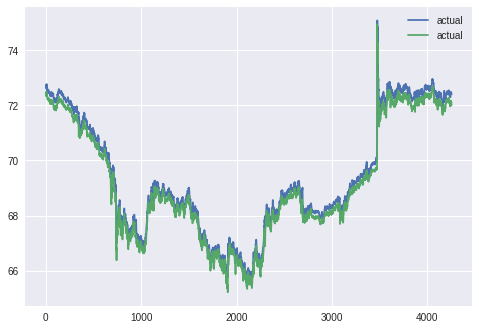

In [63]:
actual = ds.test['A'][60:]
actual.reset_index(drop=True, inplace=True)
plt.plot(pred['open'], label='actual')
plt.plot(actual['open'], label='actual')
plt.legend()
#plt.savefig('./gdrive/My Drive/sp500_A_ckpt/A_plot.png', format='png', )
plt.show()

In [47]:
!ls './gdrive/My Drive/sp500_A_ckpt/'

A_plot.png	    model.04-0.00.hdf5	model.10-0.00.hdf5  model.19-0.00.hdf5
model.01-0.00.hdf5  model.06-0.00.hdf5	model.13-0.00.hdf5  tb_summary
model.02-0.00.hdf5  model.07-0.00.hdf5	model.15-0.00.hdf5
model.03-0.00.hdf5  model.08-0.00.hdf5	model.16-0.00.hdf5
